This notebook was made to train a model to discover credit card frauds, it makes use of both SQL and machine learning to make the dataframe and test it.

1. Import libraries

In [44]:
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score

2. Load dataset

In [45]:
df = pd.read_csv("creditcard.csv", usecols=["Class", "Amount", "V27", "V28"])

df.head()


,V27,V28,Amount,Class
0,0.133558,-0.021053,149.62,0
1,-0.008983,0.014724,2.69,0
2,-0.055353,-0.059752,378.66,0
3,0.062723,0.061458,123.50,0
4,0.219422,0.215153,69.99,0


3. Create the database

In [46]:
df['transaction_id'] = df.index 


conn = sqlite3.connect("creditcard_fraud.db")
df.to_sql("transactions", conn, if_exists="replace", index=False)


284807

4. Storing the dataset onto the database and ensuring it exists

In [47]:
%load_ext sql
%sql sqlite:///creditcard_fraud.db

#checking if table exists as required
%sql SELECT name FROM sqlite_master WHERE type='table';

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
 * sqlite:///creditcard_fraud.db
Done.


name
transactions


5. Selecting relevant information from the dataset using SQL queries

In [48]:


query = """
SELECT Amount, V27, V28, Class
FROM transactions
"""
df_sql = pd.read_sql(query, conn)


In [49]:
print(df_sql['Class'].value_counts())


Class
0    284315
1       492
Name: count, dtype: int64


This code above is to check the balance of classes, it can be seen that the class is very imbalanced so using SMOTE might prove useful to better handle the data

6. Training a random forest model

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df_sql[["Amount", "V27", "V28"]]
y = df_sql["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.19      0.32        98

    accuracy                           1.00     56962
   macro avg       0.93      0.60      0.66     56962
weighted avg       1.00      1.00      1.00     56962



From here we can see that the model has very high precision in frauds, usually getting them correct. However, it hardly picks up on any frauds which has lead to a low f1-score.

This means SMOTE must be used, it will create synthetic examples of the fraud class by interpolating the existing data which is not the same as just duplicating data making it a reliable technique.

However, we need to gauge how cautious we want the smote to be. The next code will find the best probability for which a prediction can be considered positive so we can balance the number of frauds caught but also reduce the number of false alarms.

In [51]:
# Finding the best threshold for classification
y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold: {best_threshold}")
print(f"F1 Score at best threshold: {max(f1_scores)}")


Best threshold: 0.37
F1 Score at best threshold: 0.35384615384615387


Despite the model being imbalanced, it's clear from here that using SMOTE will actually reduce the effectiveness of the model. F1-score considers both precision and recall so that's the metric I've chosen to gauge effectiveness here.

If the best probability is 1 that might suggest that the class may be extremely imbalanced (given it's 98 positives out of around 57000). So the model becomes too sensitive, even more than a standard random forest.

As an improvement, an XGBClassifier may be tried to give a better model but it will need specific tuning for imbalanced datasets.

7. Plotting a confusion matrix to better analyse the random forest model

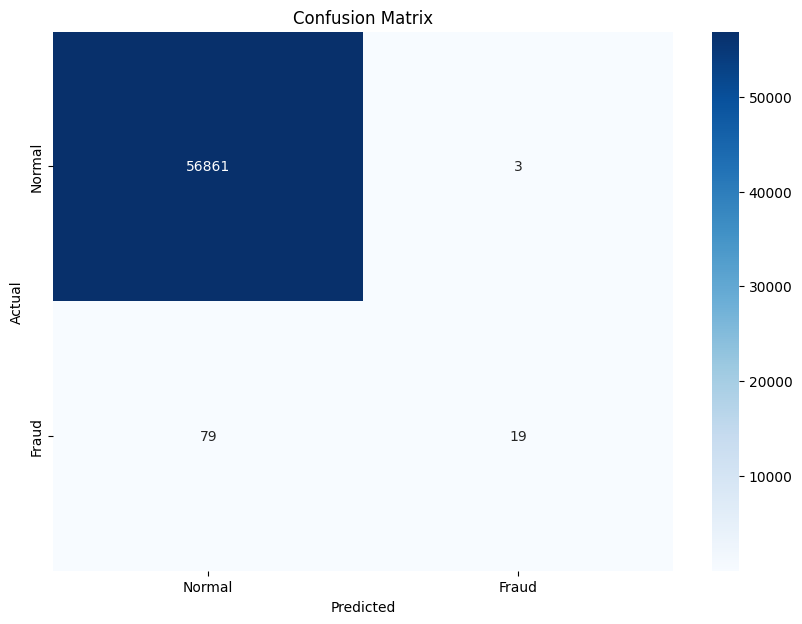

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)   
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From here the effectiveness of the model is further reinforced as it has predicted 79 cases to be fraud, missing 19. It also only predicted 3 normal cases to be fraud.

8. A PRC can be made to show the effectiveness of the model even further

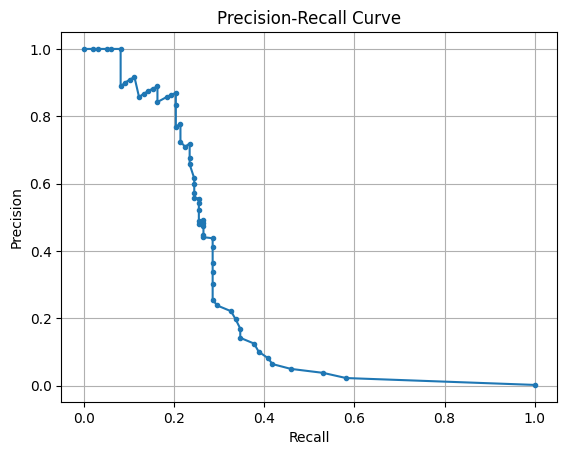

AUPRC: 0.27085465313340545


In [53]:
import matplotlib.pyplot as plt

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
auprc = auc(recall, precision)

print("AUPRC:", auprc)

A precision curve above has also been made and it shows that the model has very high precision at low recall but drops sharply. This further proves that our model is very cautious as we described earlier. 

Calculating the area under the curve gave 0.27 which is expected as given the dataset, if we were to try to improve the recall we'd just be running into the normal cases and calling them fraudulent given there are actually so few fraud cases available.

9. Create ROC curve

ROC AUC (Random Forest): 0.8449658440331675


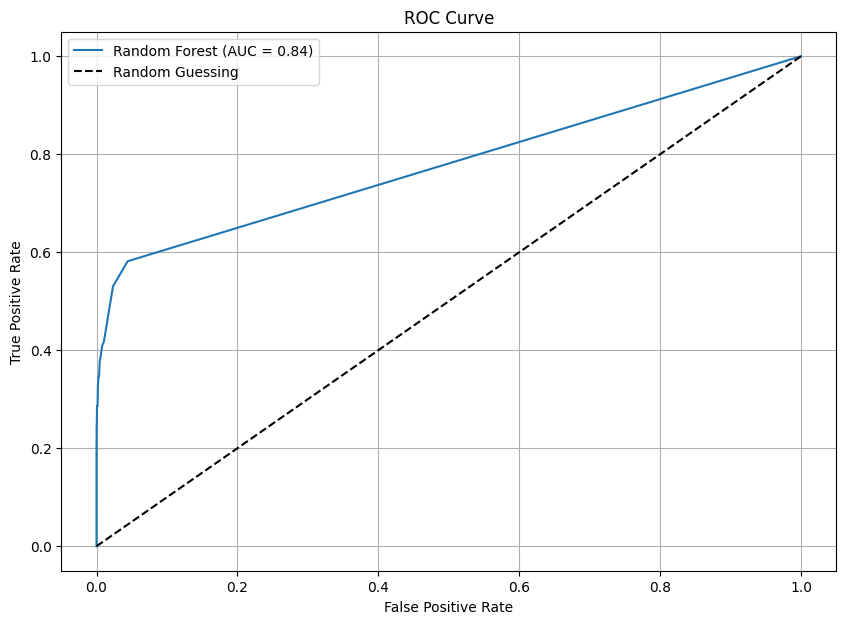

In [54]:
from sklearn.metrics import roc_auc_score

print("ROC AUC (Random Forest):", roc_auc_score(y_test, y_scores_rf))


# Plotting ROC Curve
from sklearn.metrics import roc_curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_scores_rf)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()



Finally, the model shows how much better it is at random guessing and the roc auc score of 0.84 shows that.

Given that this was a highly imbalanced dataset, I was concerned the random forest may have been to cautious which would have effected its utility citing the use of smote as a better way to improve it. However, under a deep analysis we can see that there is no problem with the model overall and it has performed to a level I did not expect.

For better experimentation, I will try to pick up a project that has a slightly less imbalanced dataset and see if smote can work on there. This will tell me if this dataset being extremely imbalanced was the problem or not. 